In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

import json

In [2]:
ENABLE_GRIDSEARCH = False

# Question 2: Applied Machine Learning

We first obtain the data and build the TF-IDF document matrix, making sure we exclude english typical stopwords (`the`, `of`, `for`, ...):

In [3]:
data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_dm = vectorizer.fit_transform(data.data)

In [4]:
tfidf_dm.shape # shape=(num_docs, num_terms)

(18846, 173451)

then we **randomly** split the data in the following way:

 - 10% for validation
 - 10% for testing
 - 80% for training

In [5]:
N = len(data.data)
t_N = int(0.1 * N)

indices = np.random.choice(range(len(data.data)),
                           size=2*t_N,
                           replace=False)

test_ids, valid_ids = indices[:t_N], indices[t_N:]
train_ids = np.setdiff1d(np.arange(N), indices, assume_unique=True)

assert len(train_ids) + len(test_ids) + len(valid_ids) == N

x_train, y_train = tfidf_dm[train_ids], data.target[train_ids]
x_val,   y_val   = tfidf_dm[valid_ids], data.target[valid_ids]
x_test,  y_test  = tfidf_dm[test_ids],  data.target[test_ids]

The grid search is performed in a two dimensional space: one dimension for the number of estimators and one for the maximal depth of the trees. We stored our result in a file to avoid lengthy computations at each run.

In [6]:
if ENABLE_GRIDSEARCH:
    # grid search n_estimators and max_depth 
    validate = lambda n, d: RandomForestClassifier(n_estimators=n, max_depth=d).fit(x_train, y_train)\
                                                                               .score(x_val, y_val)
    accuracies = []
    for n in range(40, 60):
        # run once with no max to get upper bound
        for depth in range(75, 90):
            score = validate(n, depth)
            accuracies.append((n, depth, score))
    
    with open('grid_search.json', 'w') as f:
        json.dump(accuracies, f)
else:
    with open('grid_search.json', 'r') as f:
        accuracies = json.load(f)

In [7]:
accuracies = sorted(accuracies, key=lambda t: t[2])

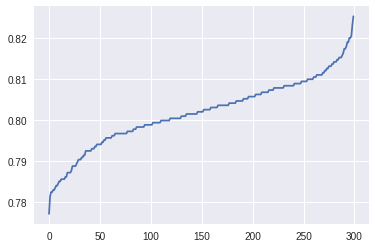

In [8]:
fig, ax = plt.subplots()
_, _, accs = zip(*accuracies)
ax.plot(accs)

The best parameters and the associated score are:

In [9]:
accuracies[-1]

[56, 86, 0.8253715498938429]

Now that we have good parameters, we can train and predict

In [10]:
n, d, _ = accuracies[-1]
rfc = RandomForestClassifier(n_estimators=n, max_depth=d)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

We declare and fill the confusion matrix

In [11]:
confusion_matrix = np.zeros((len(data.target_names), len(data.target_names)))
categories = np.sort(np.unique(data.target))

for predicted_class in categories:
    reals = y_test[np.where(predictions == predicted_class)]
    for actuals_class in reals:
        confusion_matrix[predicted_class, actuals_class] += 1

As this is quite a large matrix, a regular table would hard to display and read at once. Therefore we decide to visualize the confusion matrix as a heatmap.

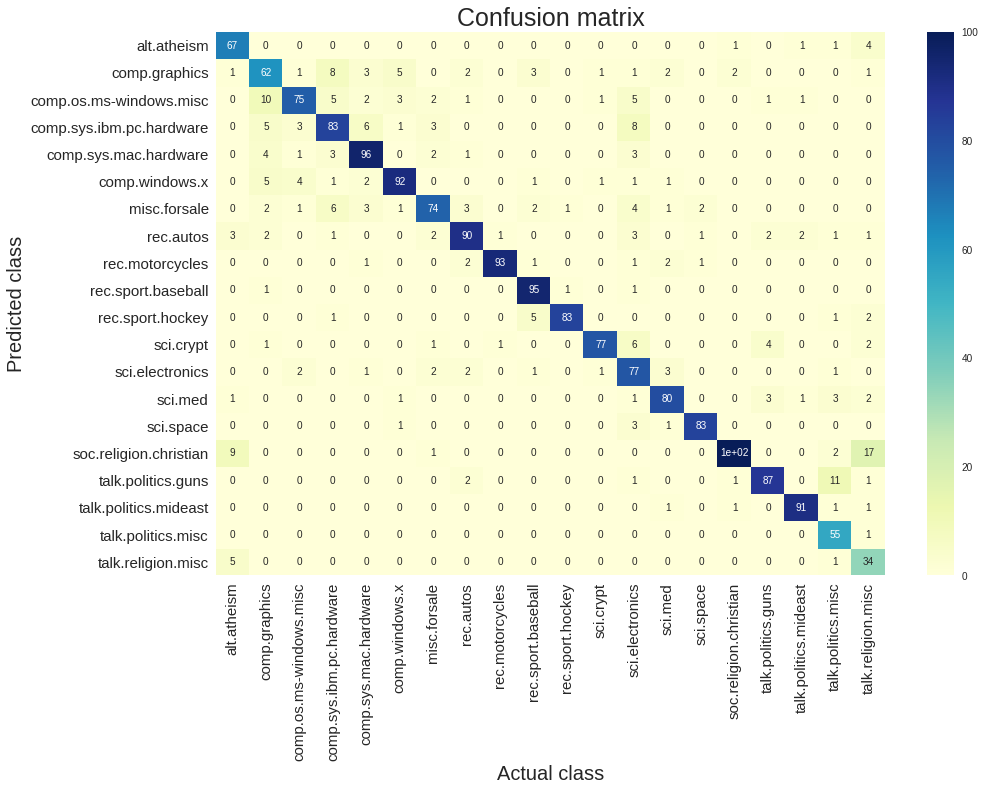

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.heatmap(confusion_matrix,
            xticklabels=data.target_names,
            yticklabels=data.target_names,
            annot=True,
            cmap='YlGnBu',
            ax=ax)

ax.set_ylabel('Predicted class').set_size(20)
ax.set_xlabel('Actual class').set_size(20)

for tick in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    tick.set_size(15)

ax.set_title('Confusion matrix').set_size(25)

In [17]:
idx_to_importance = zip(range(len(rfc.feature_importances_)), rfc.feature_importances_)
indices, importances = zip(*sorted(idx_to_importance, key=lambda t: t[1]))

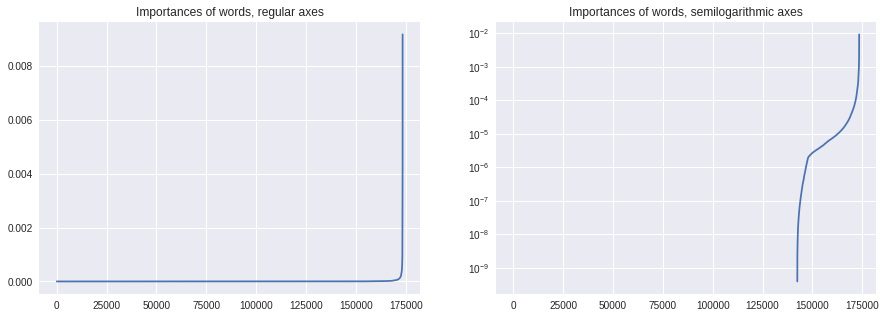

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.plot(importances)
ax1.set_title('Importances of words, regular axes')
ax2.semilogy(importances)
ax2.set_title('Importances of words, semilogarithmic axes')

we observe that a few features have very high importance. Knowing that each feature is a term, let's see what words are the most important in the classification:

In [19]:
vocabulary = {idx: word for word, idx in vectorizer.vocabulary_.items()}

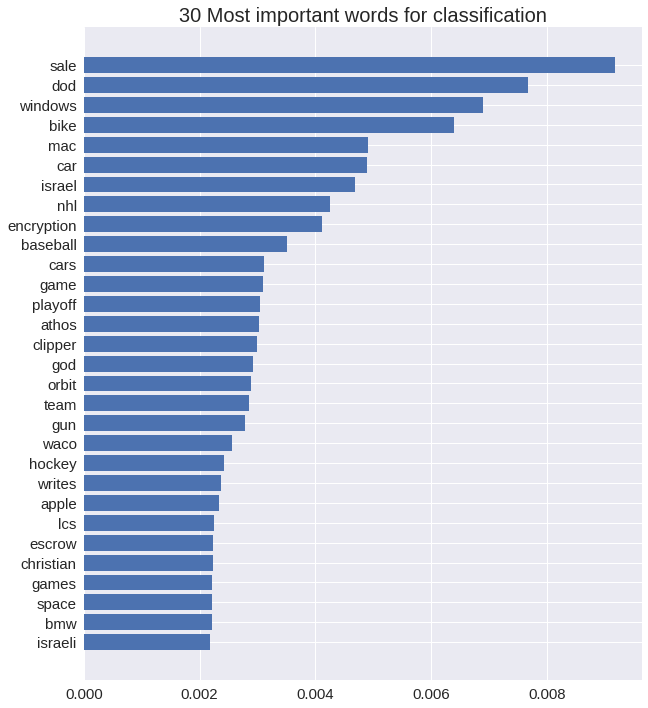

In [31]:
N = 30
words = [vocabulary[idx] for idx in indices[-N:]]

fig, ax = plt.subplots(figsize=(10, 12))

ax.barh(range(N), importances[-N:], tick_label=words)

ax.set_title(str(N) + ' Most important words for classification').set_size(20)

for tick in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    tick.set_size(15)